In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [2]:
!pip install POT

In [3]:
import ot

In [4]:
def MMD(K,x_idx,permutations=None,rng=np.random.default_rng(0)):
    m = np.sum(x_idx)
    n = len(x_idx)-m

    K_X = K[x_idx, x_idx]
    K_Y = K[~x_idx, ~x_idx]
    K_X_Y =  K[x_idx, ~x_idx]
    div = np.mean(K_X) + np.mean(K_Y) - 2*np.mean(K_X_Y)

    if permutations is not None:
        shuffled_tests = np.zeros((permutations, 1))
        for b in range(permutations):
            new_x_idx = x_idx[rng.permutation(len(x_idx))]
            shuffled_tests[b] =MMD(K, new_x_idx)

        pvalue = np.mean(div<=shuffled_tests)
        return div, pvalue
    else:
        return div

In [5]:
def MLW(K,x_idx,p_W=2,permutations=None,do_sort_only_once=True, rng=np.random.default_rng(0)):
    m = np.sum(x_idx)
    n = len(x_idx)-m

    K_X_Z = K[x_idx, :]
    K_Y_Z = K[~x_idx, :]
    landmark_idx,div = MLW_sorted(np.sort(K_X_Z,axis=0),np.sort(K_Y_Z,axis=0),p_W);

    if permutations is not None:
        shuffled_tests = np.zeros((permutations, 1))
        if m != n:
            acute_p, acute_i, acute_j = northwest_corner_rule_iid(m,n)

        if do_sort_only_once:
            v=np.argsort(K,axis=1) # sorts per row
            row_X = np.repeat(np.arange(m+n),m)
            row_Y = np.repeat(np.arange(m+n),n)
            for b in range(permutations):
                pb = np.random.permutation(m+n)
                aK_Z_X = K[row_X, v[pb[v]<m] ].reshape(m+n,m)
                aK_Z_Y = K[row_Y, v[pb[v]>=m]].reshape(m+n,n)
                if m==n:
                    shuffled_tests[b] = np.max(np.mean(np.abs(aK_Z_X - aK_Z_Y)**p_W, axis=1))
                else:
                    shuffled_tests[b] = np.max(np.dot(np.abs(aK_Z_X[:,acute_i]-aK_Z_Y[:,acute_j])**p_W, acute_p))
        else:
            for b in range(permutations):
                new_x_idx = x_idx[rng.permutation(len(x_idx))]
#                _,shuffled_tests[b] = MLW(K, new_x_idx, p_W)
                if m==n:
                    shuffled_tests[b] = np.max(np.mean(np.abs(np.sort(K[new_x_idx, :],axis=0) - np.sort(K[~new_x_idx, :],axis=0))**p_W, axis=0))
                else:
                    shuffled_tests[b] = np.max(np.dot(np.abs(np.sort(K[:,new_x_idx],axis=1)[:,acute_i]-np.sort(K[:,~new_x_idx],axis=1)[:,acute_j])**p_W, acute_p))

        pvalue = np.mean(div<=shuffled_tests)
        return landmark_idx, div, pvalue
    else:
        return landmark_idx, div

def northwest_corner_rule_iid(m,n):
    # for sorted don't need data
    acute_p,acute_indices,_ = ot.lp.emd_wrap.emd_1d_sorted(
        np.full(m,1/m),np.full(n,1/n),1.0+np.arange(m),1.0+np.arange(n))
    acute_i, acute_j = acute_indices[:,0],acute_indices[:,1]
    return acute_p, acute_i, acute_j


def MLW_sorted(K_X_Z, K_Y_Z, p_W):
    m = K_X_Z.shape[0]
    n = K_Y_Z.shape[0]

    if m==n:
        landmark_divs = np.mean(np.abs(K_X_Z - K_Y_Z)**p_W, axis=0)
    else:
        acute_p, acute_i, acute_j = northwest_corner_rule_iid(m,n)
        landmark_divs = (acute_p[:,np.newaxis].T@np.abs(K_X_Z[acute_i]-K_Y_Z[acute_j])**p_W).squeeze()

    landmark_idx = np.argmax(landmark_divs)
    return landmark_idx, landmark_divs[landmark_idx]

In [6]:
def sqeuclidean(X):
    n, _ = X.shape  # [n,d] = size(X);
    # form pairwise distance matrix (squared Euclidean)
    D2 = np.maximum(0, -2 * (X @ X.T)
                    + np.sum(X**2, axis=1, keepdims=True)
                    + (np.sum(X**2, axis=1, keepdims=True)).T) # n_size * 2, n_size * 2

    return D2

In [7]:
def gaussian_kernel(X, kernel_size=None):
    n, _ = X.shape  # [n,d] = size(X);
    # X = (n_size * 2, d)
    def rbf2(D2, kernel_size):
       return np.exp(-D2 / (2 * kernel_size ** 2))
    # form pairwise distance matrix (squared Euclidean)
    D2 = sqeuclidean(X)

    # find the median kernel size
    if kernel_size is None:
        kernel_size = np.nanmedian(np.ravel(np.sqrt(D2) + sparse.spdiags(np.nan, 0, n, n)))

    K = rbf2(D2, kernel_size) # n_size * 2, n_size * 2
    K = (K + np.transpose(K)) / 2 # n_size * 2, n_size * 2
    return K, kernel_size

In [8]:
def make_clusters(m,n,n_clusters,prevalence_of_missing=None, rng=np.random.default_rng(0)):
    if prevalence_of_missing is None:
        prevalence_of_missing =0.5/n_clusters

    angles = np.arange(0,2*np.pi,2*np.pi/n_clusters)
    clusters = 8*np.hstack((np.cos(angles)[:,np.newaxis],np.sin(angles)[:,np.newaxis]))

    x_i = rng.choice(n_clusters,size=m)
    p = np.full(n_clusters,(1-prevalence_of_missing)/(n_clusters-1))
    p[-1] = prevalence_of_missing
    y_i = rng.choice(n_clusters,size=n,p=p)
    return rng.normal(0,1,size=(m,2))+clusters[x_i], rng.normal(0,1,size=(n,2))+clusters[y_i]


78 0.003820117220037747


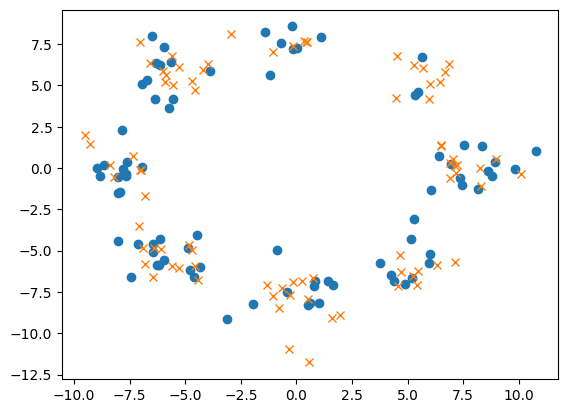

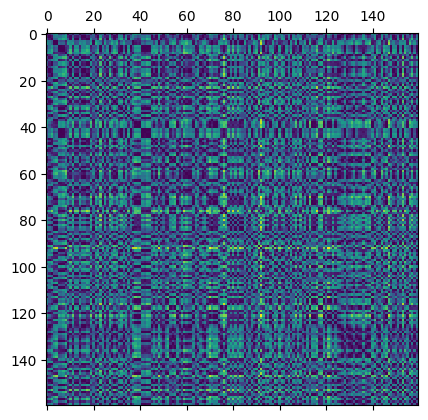

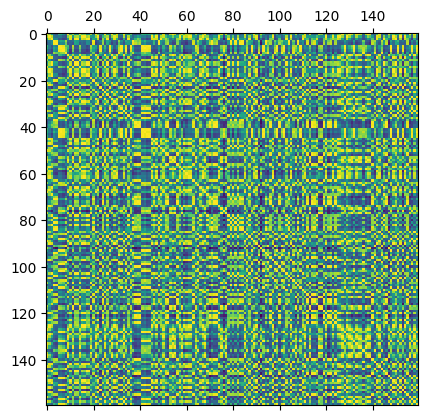

In [9]:
m, n = 80, 80
n_clusters = 8;
x,y = make_clusters(m,n,n_clusters)

plt.plot(x[:,0],x[:,1],'o')
plt.plot(y[:,0],y[:,1],'x')

z = np.vstack((x,y))
x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
D2 = sqeuclidean(z)
K,kernel_size = gaussian_kernel(z)
plt.matshow(D2)
plt.matshow(K)


idx,div = MLW(K,x_idx);
print(idx,div)

In [10]:
import time

In [32]:
m, n = 200, 200
n_clusters = 8;

ns = np.round(np.logspace(2,np.log10(5000),15)).astype(int)

times = np.zeros((len(ns),3))
divs = np.zeros((len(ns),3))

for i,n in enumerate(ns):
    m = n
    x,y = make_clusters(m,n,n_clusters,0)
    z = np.vstack((x,y))
    x_idx = 1==np.concatenate((np.ones(m),np.zeros(n)))
    start = time.time()
    D2 = sqeuclidean(z)
    div0 = np.sqrt(ot.emd2([],[],D2))
    end = time.time()
    times[i,0] = end - start
    divs[i,0] = div0


    start = time.time()
    K,kernel_size = gaussian_kernel(z)
    div1 = np.sqrt(MMD(K,x_idx))
    end = time.time()
    times[i,1] = end - start
    divs[i,1] = div1



    start = time.time()
    K,kernel_size = gaussian_kernel(z)
    _,div2 = MLW(K,x_idx)
    end = time.time()
    times[i,2] = end - start
    divs[i,2] = div2
    print(i,n,times[i,:])

0 100 [0.00729442 0.0026598  0.00358367]
1 132 [0.00798082 0.00323844 0.00598264]
2 175 [0.01647758 0.00653005 0.01308084]
3 231 [0.0316143  0.00990868 0.03372383]
4 306 [0.06665158 0.02155948 0.048913  ]
5 404 [0.11552    0.03723121 0.08788681]
6 535 [0.18413138 0.07233047 0.14156246]
7 707 [0.34885073 0.12665081 0.24455309]
8 935 [0.57050657 0.2116487  0.40213943]
9 1237 [1.22287822 0.45508862 1.05296493]
10 1635 [2.64798474 0.6726203  1.39061093]
11 2162 [3.88081646 1.05858183 2.40322852]
12 2859 [8.14597654 1.90754342 4.45785832]
13 3781 [16.54884028  4.36499166  9.16996312]
14 5000 [26.00567889  6.82306218 15.75132799]


Text(0.5, 1.0, 'Python/Cython')

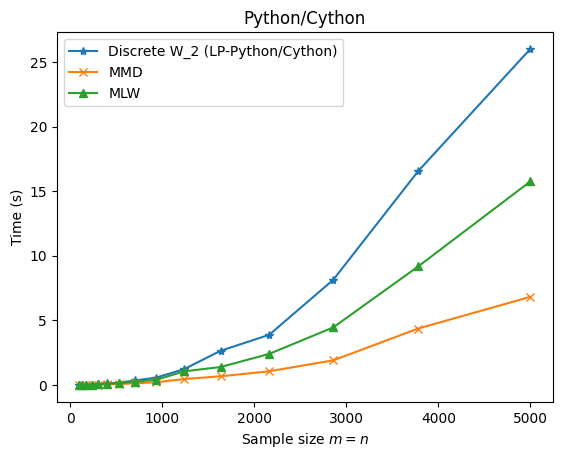

In [35]:
plt.plot(ns,times[:,0],marker='*',label='Discrete W_2 (LP-Python/Cython)')
plt.plot(ns,times[:,1],marker='x',label='MMD')
plt.plot(ns,times[:,2],marker='^',label='MLW')

#plt.plot(ns,5e-10*ns**3,label=r'$\mathcal{O}(n^3)$')
#plt.plot(ns,8e-8*ns**2*np.log(ns),label=r'$\mathcal{O}(n^2\log(n))$')
plt.legend()
plt.xlabel('Sample size $m=n$')
plt.ylabel('Time (s)')
plt.title('Python/Cython')